In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
from tqdm import tqdm

from pdb import set_trace


In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./lenet_mnist_model.pth"
use_cuda=True

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [90]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=32, shuffle=True)


In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

##FGSM Attack

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [91]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    attacked = 0
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # print("init_pred: ", init_pred)
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            attacked += 1
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    final_attacked = attacked/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples,final_attacked

In [24]:
accuracies = []
examples = []
at_sr = []
# Run test for each epsilon
for eps in epsilons:
    acc, ex, at = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)
    at_sr.append(at)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9425 / 10000 = 0.9425
Epsilon: 0.1	Test Accuracy = 8513 / 10000 = 0.8513
Epsilon: 0.15	Test Accuracy = 6843 / 10000 = 0.6843
Epsilon: 0.2	Test Accuracy = 4330 / 10000 = 0.433
Epsilon: 0.25	Test Accuracy = 2111 / 10000 = 0.2111
Epsilon: 0.3	Test Accuracy = 875 / 10000 = 0.0875


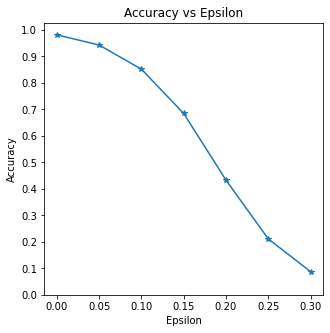

In [30]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig("FGSM_Mnist_acc.pdf", format = 'pdf', bbox_inches='tight')
plt.show()


In [27]:
print(at_sr)

[0.0, 0.0385, 0.1297, 0.2967, 0.548, 0.7699, 0.8935]


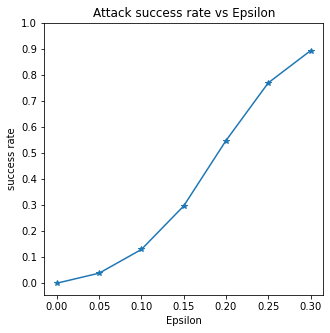

In [31]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, at_sr, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack success rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("success rate")
plt.savefig("FGSM_Mnist_atsr.pdf", format = 'pdf', bbox_inches='tight')
plt.show()

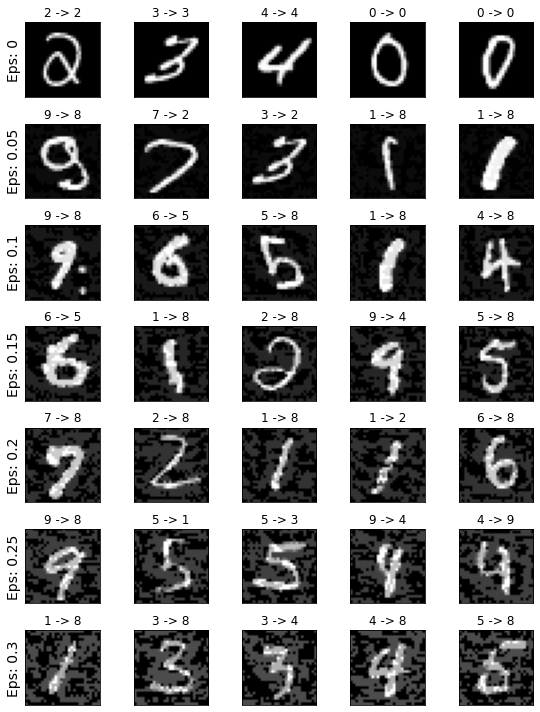

In [32]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.savefig("FGSM_Mnist.pdf", format = 'pdf', bbox_inches='tight')
plt.show()

##C&W


In [33]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader(): #wrap a dataloader to move data to a device
  def __init__(self, dl, device): 
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)
 #yield a batch of data after moving it to a device

  def __len__(self):
    return len(self.dl) #number of batches

CUDA Available:  True


In [117]:
def cw_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01) :

    images = images.to(device)     
    labels = labels.to(device)

    # Define f-function
    def f(x,labels) :

        outputs = model(x).to(device)
        labels = labels.to(device)
        ou = outputs[0].to('cpu')
        la = labels.to('cpu')
        one_hot_labels = torch.eye(len(ou))[la].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())
        
        # If targeted, optimize for making the other class most likely 
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        # If untargeted, optimize for making the other class most likely 
        else :
            return torch.clamp(j-i, min=-kappa)
    
    w = torch.zeros_like(images, requires_grad=True).to(device)
    optimizer = optim.Adam([w], lr=learning_rate)

    prev = 1e10
    

    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c*f(a,labels))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if step % (max_iter//10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                return a, loss1
            prev = cost
        
        # print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = 1/2*(nn.Tanh()(w) + 1)

    return attack_images, loss1

In [57]:
lbls = ['0','1','2','3','4','5','6','7','8','9']
def visualize(images, adversarials, reals, labels, predicted, modiff, number,target=-1,save=""):
    # adversarials = adversarials + images
    # images = torch.clamp(images,0,1)
    # adversarials = torch.clamp(adversarials,0,1)
    # images = denormalize(images.cpu().detach().numpy())
    # adversarials = denormalize(adversarials.cpu().detach().numpy())
    adversarials= adversarials.cpu().detach().numpy()
    images = images.cpu().detach().numpy()
    modiff = modiff.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    reals = reals.cpu().detach().numpy()
    predicted = predicted.cpu().detach().numpy()
    images = np.transpose(images, [0, 2, 3, 1])
    adversarials = np.transpose(adversarials, [0, 2, 3, 1])
    modiff = np.transpose(modiff, [0, 2, 3, 1])
    # adversarials = np.round(adversarials*255).astype(int)
    # images = np.round(images*255).astype(int)

    if(number>0):
      fig, axes = plt.subplots(3, number, figsize=(5*number, 12))
      count = i = j = 0
      
      while count != number and i<len(labels):
        if(target<0):
          while (labels[i]!=reals[i] or predicted[i]==reals[i]) and i<len(labels)-1:
            i+=1
          if((labels[i]!=reals[i] or predicted[i]==labels[i])):
            break
        else:
          while (labels[i]!=reals[i] or predicted[i]==reals[i] or predicted[i]!=target) and i<len(labels)-1:
            i+=1
          if(labels[i]!=reals[i] or predicted[i]==labels[i]or predicted[i]!=target):
            break
        
        if number>1:
          count+=1
          axes[0, j].imshow(images[i],cmap="gray")
          axes[1, j].imshow(adversarials[i],cmap="gray")
          axes[2, j].imshow(modiff[i],cmap="gray")
          axes[0, j].set_title("Original: {}".format(lbls[labels[i]]))
          axes[1, j].set_title("Adversarial: {}".format(lbls[predicted[i]]))
          axes[2, j].set_title("modiff: ")
          axes[0, j].axis('off')
          axes[1, j].axis('off')
          axes[2, j].axis('off')
          i+=1
          j+=1
        else:
          count+=1
          axes[0].imshow(images[i],cmap="gray")
          axes[1].imshow(adversarials[i],cmap="gray")
          axes[2].imshow(modiff[i],cmap="gray")
          axes[0].set_title("Original: {}".format(lbls[labels[i]]))
          axes[1].set_title("Adversarial: {}".format(lbls[predicted[i]]))
          axes[2].set_title("modiff: ")
          axes[0].axis('off')
          axes[1].axis('off')
          axes[2].axis('off')
      if save!="":
        plt.savefig('C&W_L2_'+save+'.pdf',format='pdf',bbox_inches='tight')
      plt.show()
      

In [118]:
def untargeted(c=2): #if im_start = true the optimization will start with the original image instead of random noise, so it wont have into account the c, the results will be a modification of all the pixels resulting on a grayish image, but the attack success rate is low, a 35-40% 
  print("Attack Image & predict label")
  model.eval()
  misclassified = to_count = total = correct = 0
  aux=0
  perturbed_images = []
  normal_images = []
  perturbed_labels = []
  predicted_labels = []
  normal_labels = []
  differences = []
  l=0
  for images, labels in test_loader:
      aux+=1
      iter_vis=0
      images = images.to(device)
      p_labels  = torch.max(model(images).data, 1)[1].to(device)

      images2,loss = cw_l2_attack(model, images, p_labels, targeted = False, c=c )
      
      labels = to_device(labels, device)
      outputs = model(images2)

      _, predicted = torch.max(outputs.data, 1)
      # set_trace()
      total += len(images)
      for i in range(len(predicted)):
        if p_labels[i]==labels[i]:
          to_count +=1
          if p_labels[i]!=predicted[i]:
            iter_vis+=1
            misclassified+=1
          else:
            correct += 1
      l+=loss
      A = (images2-images)
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      A+=0.5

      # print(len(labels), len(p_labels), len(predicted))
      # number = min(18,iter_vis)
      # visualize(images,images2, labels, p_labels, predicted,A, number)
      # if(aux%10==0):
      #   visualize(images,images2, labels, p_labels, predicted,A, number)
      perturbed_images.append(images2)
      normal_images.append(images)
      perturbed_labels.append(p_labels)
      predicted_labels.append(predicted)
      normal_labels.append(labels)
      differences.append(A)
  print('Correctamente etiquetados: ', to_count ,'Misclassified: ', misclassified, 'Correct: ', correct, 'Total: ',total, 'Incorrectos: ', total-to_count)
  visualize(torch.cat(normal_images),torch.cat(perturbed_images), torch.cat(normal_labels), torch.cat(perturbed_labels), torch.cat(predicted_labels),torch.cat(differences), 5, save="c"+str(c))
  A_sr =  misclassified / to_count
  P_sr = correct / total
  print('Accuracy of the network on the', to_count,' test images: %d %%' % (100 * A_sr))
  l /= len(test_loader)
  print('Loss: ', l)
  return misclassified, correct,l

  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-117-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


c=  0.01
Attack Image & predict label
Correctamente etiquetados:  9810 Misclassified:  10 Correct:  9800 Total:  10000 Incorrectos:  190


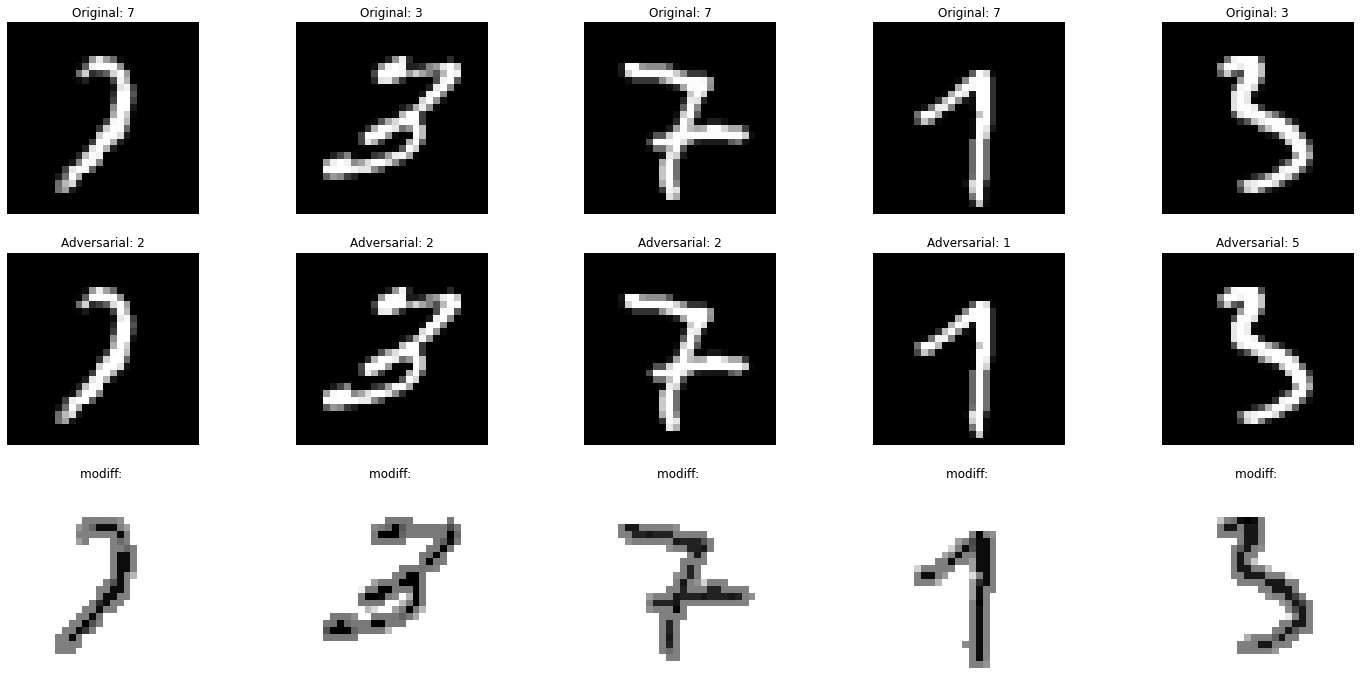

 17%|█▋        | 1/6 [10:01<50:07, 601.50s/it]

Accuracy of the network on the 9810  test images: 0 %
Loss:  tensor(17.9829, device='cuda:0', grad_fn=<DivBackward0>)
c=  0.1
Attack Image & predict label


<ipython-input-117-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Correctamente etiquetados:  9810 Misclassified:  11 Correct:  9799 Total:  10000 Incorrectos:  190


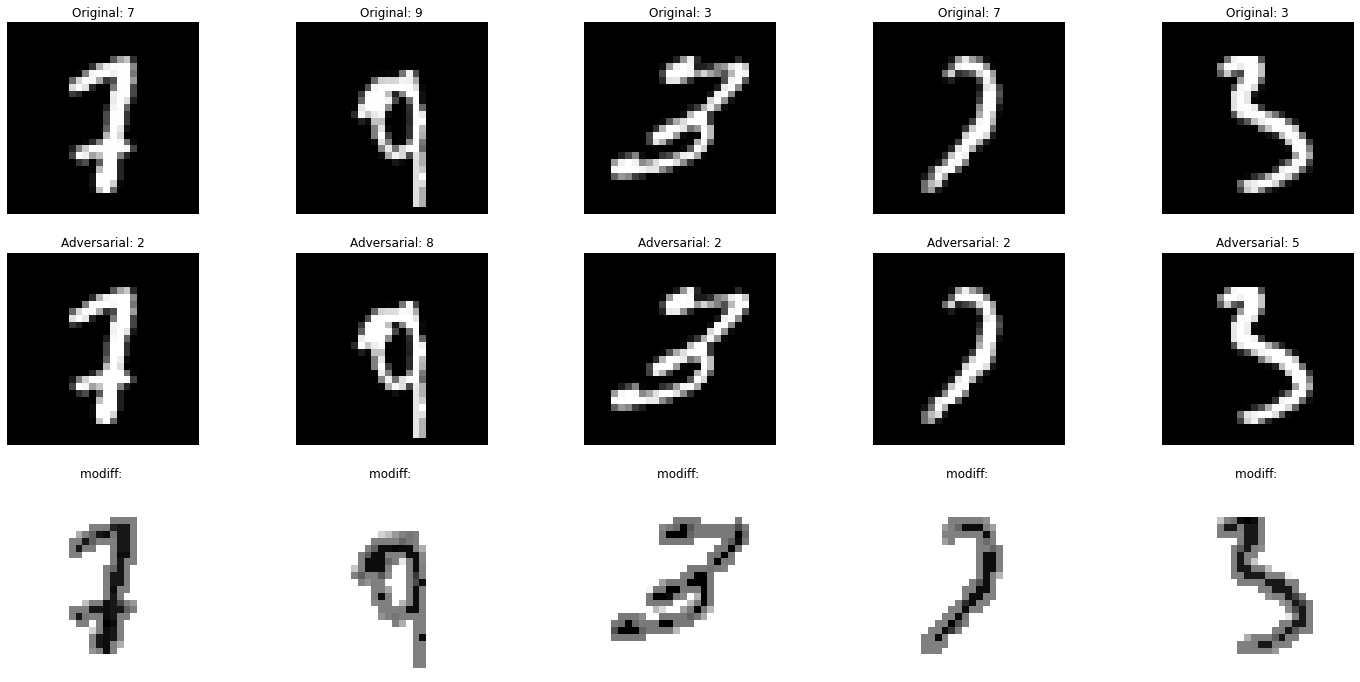

 33%|███▎      | 2/6 [19:58<39:54, 598.72s/it]

Accuracy of the network on the 9810  test images: 0 %
Loss:  tensor(18.0212, device='cuda:0', grad_fn=<DivBackward0>)
c=  1
Attack Image & predict label


<ipython-input-117-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Correctamente etiquetados:  9810 Misclassified:  79 Correct:  9731 Total:  10000 Incorrectos:  190


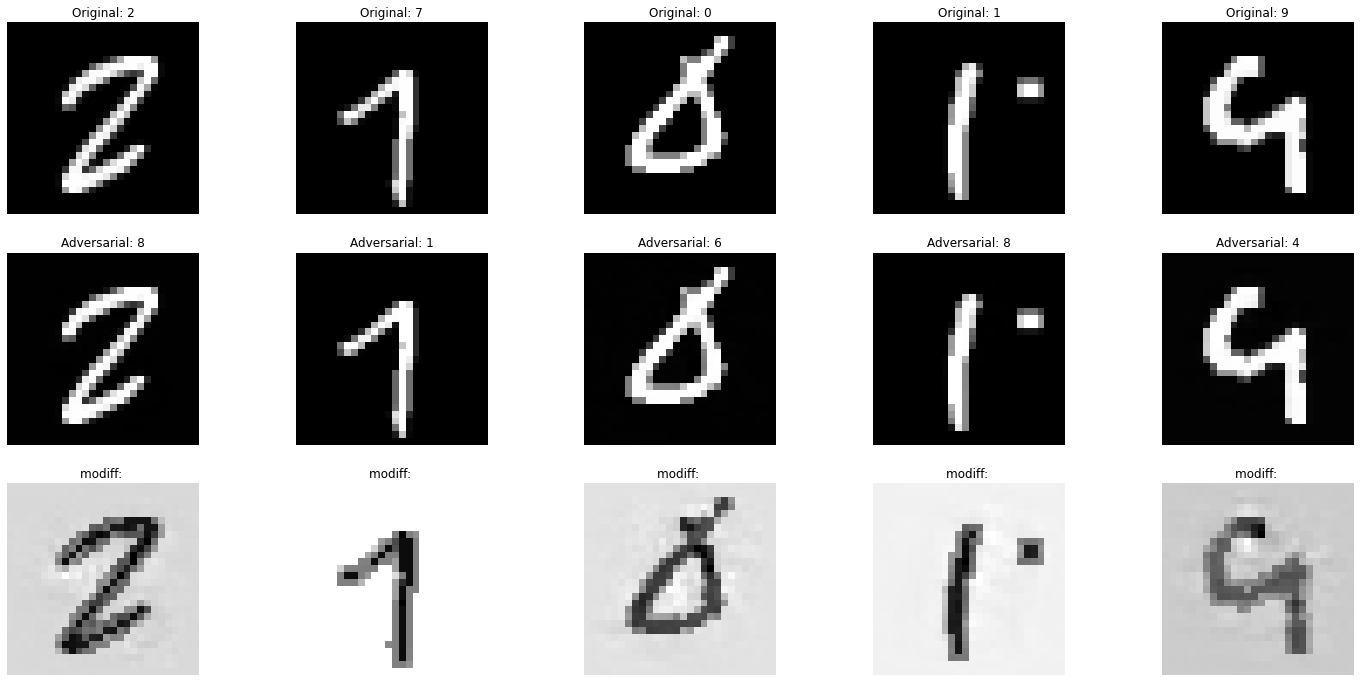

 50%|█████     | 3/6 [29:47<29:43, 594.52s/it]

Accuracy of the network on the 9810  test images: 0 %
Loss:  tensor(19.1439, device='cuda:0', grad_fn=<DivBackward0>)
c=  10
Attack Image & predict label


<ipython-input-117-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Correctamente etiquetados:  9810 Misclassified:  5156 Correct:  4654 Total:  10000 Incorrectos:  190


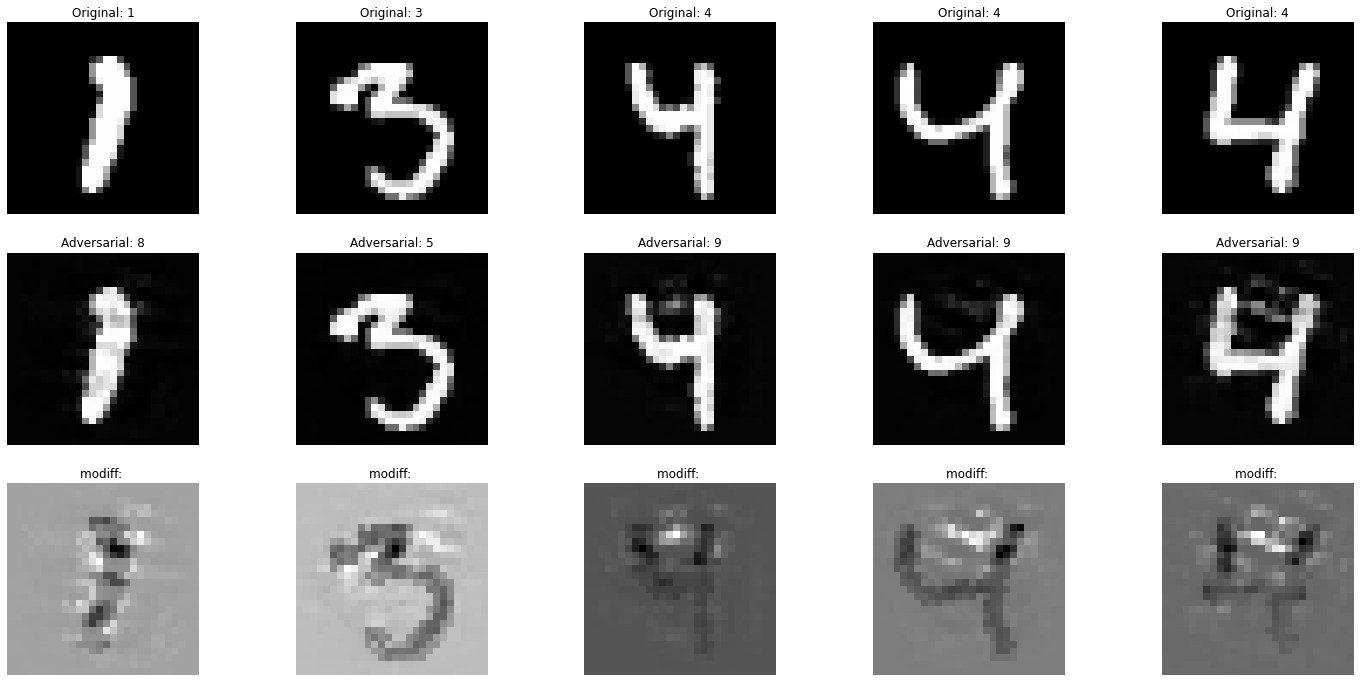

 67%|██████▋   | 4/6 [39:32<19:41, 590.79s/it]

Accuracy of the network on the 9810  test images: 52 %
Loss:  tensor(94.3400, device='cuda:0', grad_fn=<DivBackward0>)
c=  100
Attack Image & predict label


<ipython-input-117-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Correctamente etiquetados:  9810 Misclassified:  9259 Correct:  551 Total:  10000 Incorrectos:  190


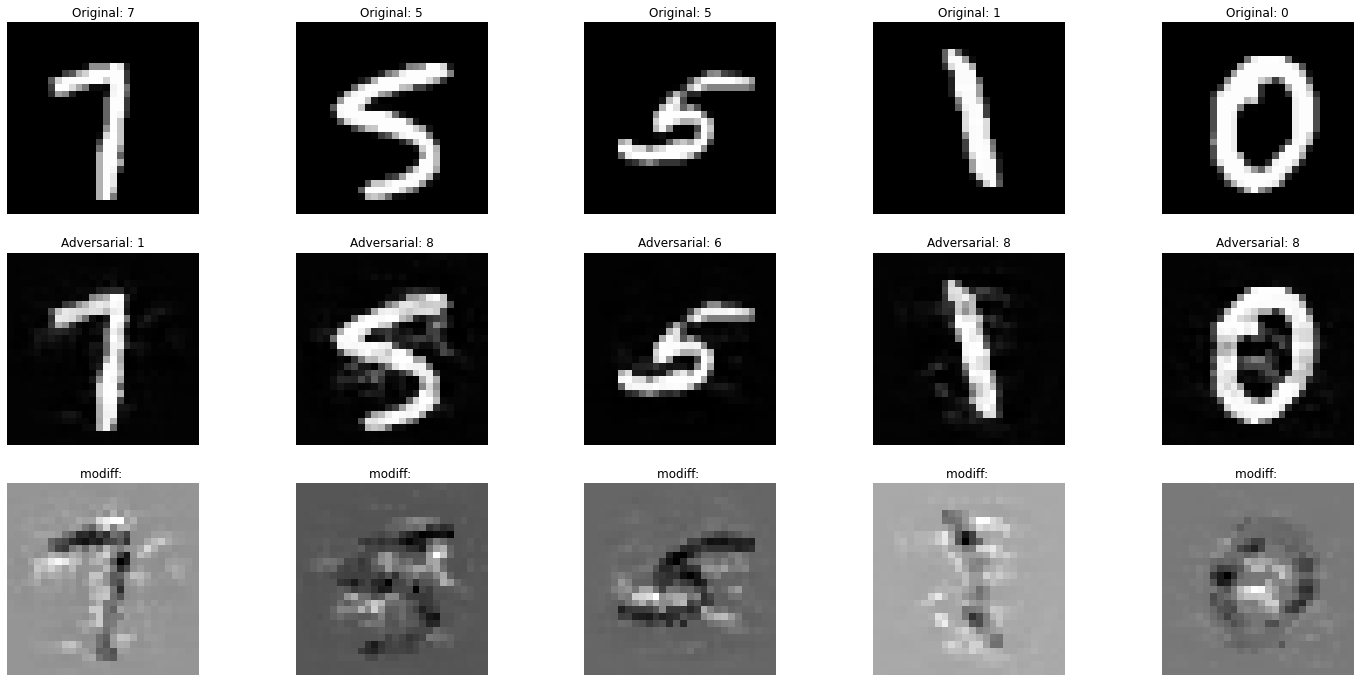

 83%|████████▎ | 5/6 [49:18<09:48, 588.98s/it]

Accuracy of the network on the 9810  test images: 94 %
Loss:  tensor(116.2769, device='cuda:0', grad_fn=<DivBackward0>)
c=  1000
Attack Image & predict label


<ipython-input-117-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Correctamente etiquetados:  9810 Misclassified:  9738 Correct:  72 Total:  10000 Incorrectos:  190


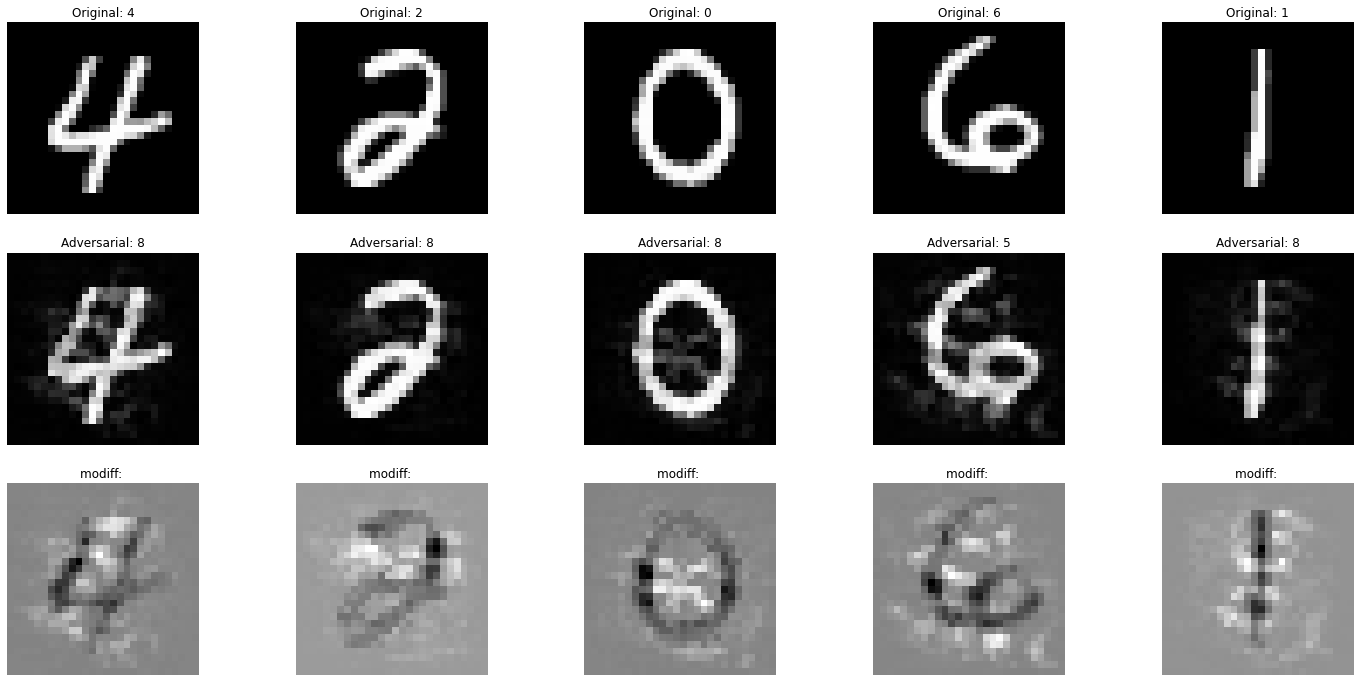

100%|██████████| 6/6 [59:03<00:00, 590.66s/it]

Accuracy of the network on the 9810  test images: 99 %
Loss:  tensor(168.9409, device='cuda:0', grad_fn=<DivBackward0>)


In [119]:
v_c = [0.01,0.1,1,10,100,1000]
acc = []
l = []
for c in tqdm(v_c):
  print("c= ",c)
  m,c,loss=untargeted(c)
  acc.append(m/(m+c))
  l.append(loss.item())

In [120]:
def plot_accuracies(c,acc,loss,save=''):
    aux = [r'$1 e-02$',r'$1 e-01$',r'$1 e+00$',r'$1 e+01$',r'$1 e+02$',r'$1 e+02$']#
    fig, ax = plt.subplots()


    ax.plot(range(len(c)),acc)
    ax.set_xlabel(r'$C$')
    # ax.xlabel(r'$C$')
    ax.set_xticks(range(len(c)),aux)
    ax.set_ylabel('Attack Success Rate')

    ax2 = ax.twinx()
    ax2.plot(range(len(c)),loss,color='red')
    ax2.set_ylabel('Mean adversarial example distance',color='red')

    # plt.title('Attack Success Rate vs. ' r'$C$')
    if save!="":
      plt.savefig('C&W_L2_'+save+'.pdf',format='pdf',bbox_inches='tight')
    plt.show()

In [96]:
aux=l

In [97]:
# convert a list of tensors to a single tensor
def concat(tensors):
    return torch.cat([t.view(-1) for t in tensors])    

In [98]:
aux=concat(aux).cpu().detach()

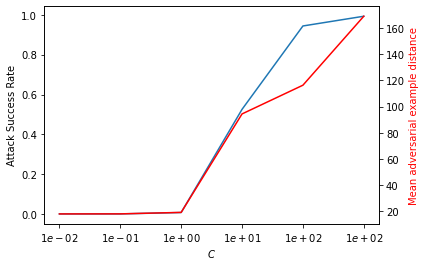

In [121]:
plot_accuracies(v_c,acc,l,save="untargted")

In [107]:
def targeted(c=2,t=0):
  print("Attack Image & predict label")
  model.eval()
  misclassified = to_count = total = correct = 0
  aux=0

  perturbed_images = []
  normal_images = []
  perturbed_labels = []
  predicted_labels = []
  normal_labels = []
  differences = []
  l=0
  for images, labels in tqdm(test_loader):
      aux+=1
      iter_vis=0
      images = images.to(device)
      p_labels  = torch.max(model(images).data, 1)[1].to(device)
      target = torch.full((images.shape[0],), t).to(device)

      images2, loss = cw_l2_attack(model, images, target, targeted = True, c=c)
      
      labels = to_device(labels, device)
      outputs = model(images2)

      _, predicted = torch.max(outputs.data, 1)
      # set_trace()
      total += len(images)
      for i in range(len(predicted)):
        if p_labels[i]==labels[i]:
          if p_labels[i]!=t:
            to_count +=1
            if predicted[i]==t:
              iter_vis+=1
              misclassified+=1
            else:
              correct += 1
      l+=loss
      A = (images2-images)
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      A+=0.5
      # print(len(labels), len(p_labels), len(predicted))
      # number = min(5,iter_vis)
      # if(aux%10==0):
      #   visualize(images,images2, labels, p_labels, predicted,A, number,t)

      perturbed_images.append(images2)
      normal_images.append(images)
      perturbed_labels.append(p_labels)
      predicted_labels.append(predicted)
      normal_labels.append(labels)
      differences.append(A)
  print('Correctamente etiquetados: ', to_count ,'Misclassified: ', misclassified, 'Correct: ', correct, 'Total: ',total, 'Incorrectos: ', total-to_count)
  visualize(torch.cat(normal_images),torch.cat(perturbed_images), torch.cat(normal_labels), torch.cat(perturbed_labels), torch.cat(predicted_labels),torch.cat(differences), 5, target=t,save="targed-"+str(t)+"c"+str(c))
  A_sr =  misclassified / to_count
  P_sr = correct / total
  print('Accuracy of the network on the', to_count,' test images: %d %%' % (100 * A_sr))
  l /= len(test_loader)
  print('Loss: ', l)
  return misclassified, correct, l

  0%|          | 0/6 [00:00<?, ?it/s]

c=  0.01
Attack Image & predict label


<ipython-input-53-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [11:16<00:00,  2.16s/it]


Correctamente etiquetados:  8840 Misclassified:  1 Correct:  8839 Total:  10000 Incorrectos:  1160


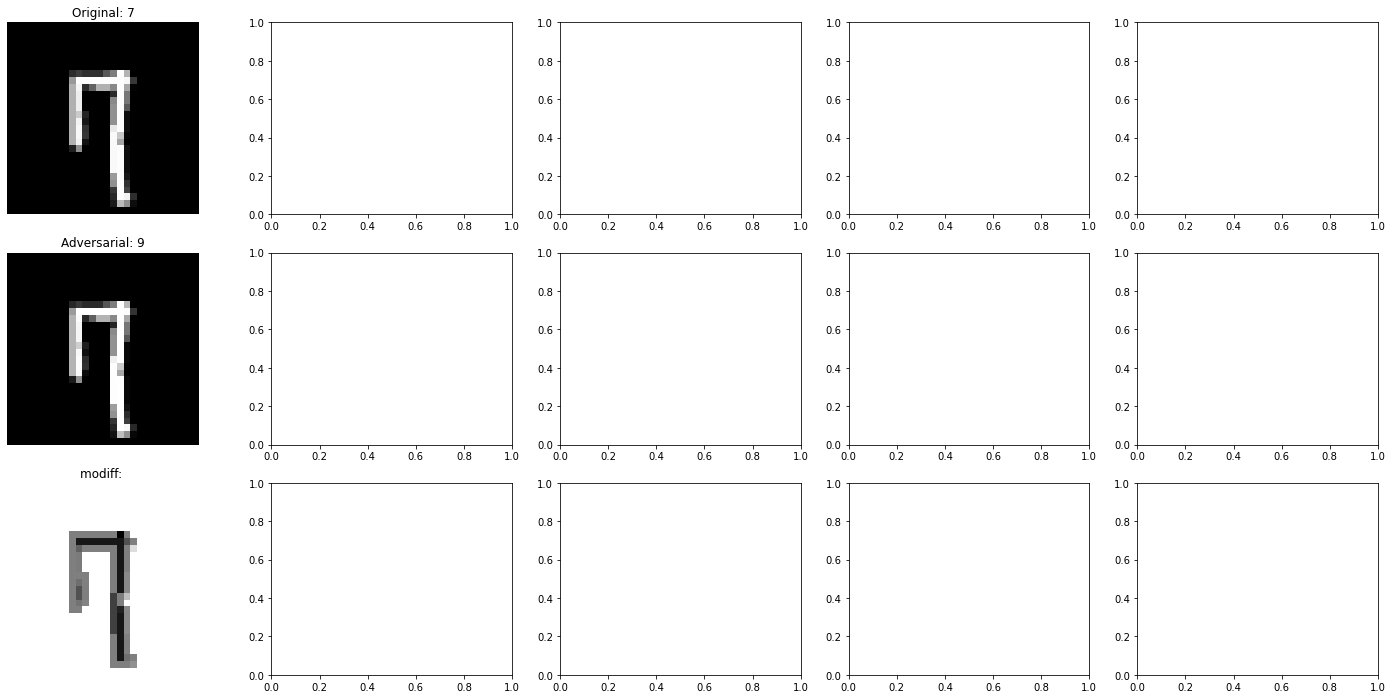

 17%|█▋        | 1/6 [11:18<56:31, 678.23s/it]

Accuracy of the network on the 8840  test images: 0 %
Loss:  tensor(17.9821, device='cuda:0', grad_fn=<DivBackward0>)
c=  0.1
Attack Image & predict label


<ipython-input-53-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [11:22<00:00,  2.18s/it]


Correctamente etiquetados:  8840 Misclassified:  1 Correct:  8839 Total:  10000 Incorrectos:  1160


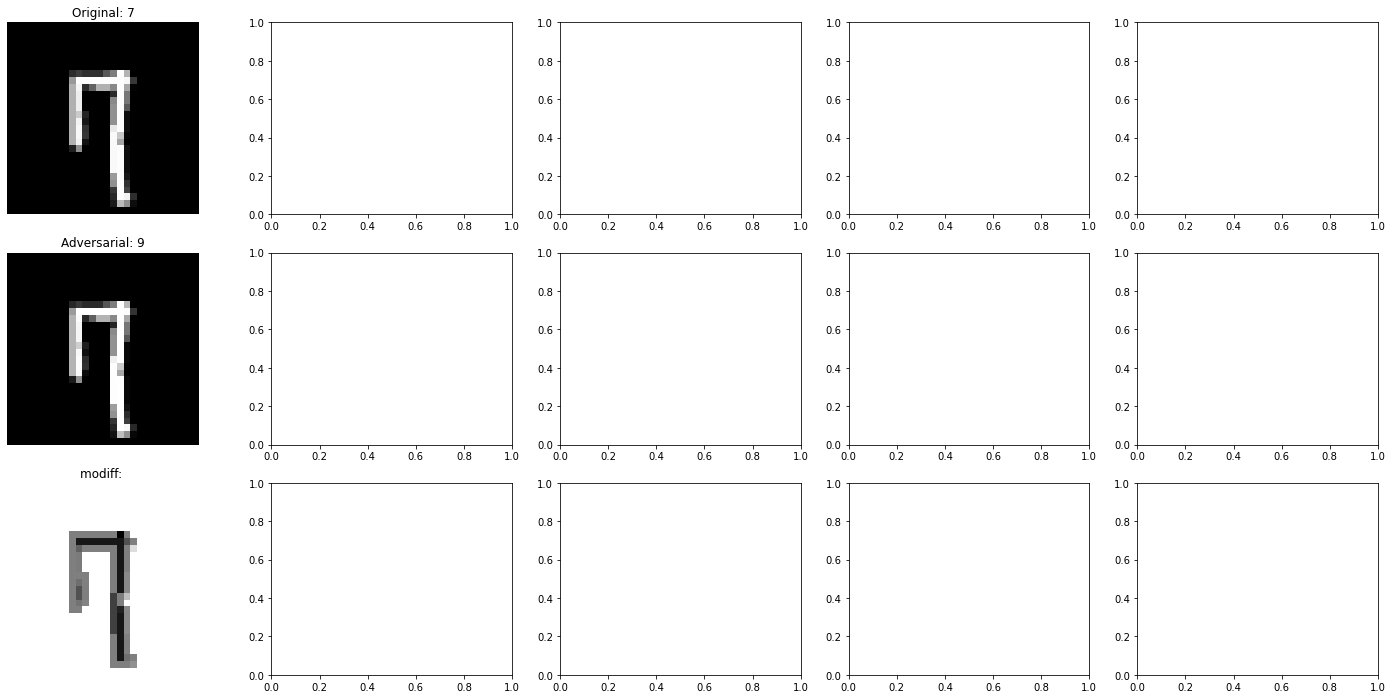

 33%|███▎      | 2/6 [22:42<45:27, 681.94s/it]

Accuracy of the network on the 8840  test images: 0 %
Loss:  tensor(18.0108, device='cuda:0', grad_fn=<DivBackward0>)
c=  1
Attack Image & predict label


<ipython-input-53-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [11:15<00:00,  2.16s/it]


Correctamente etiquetados:  8840 Misclassified:  12 Correct:  8828 Total:  10000 Incorrectos:  1160


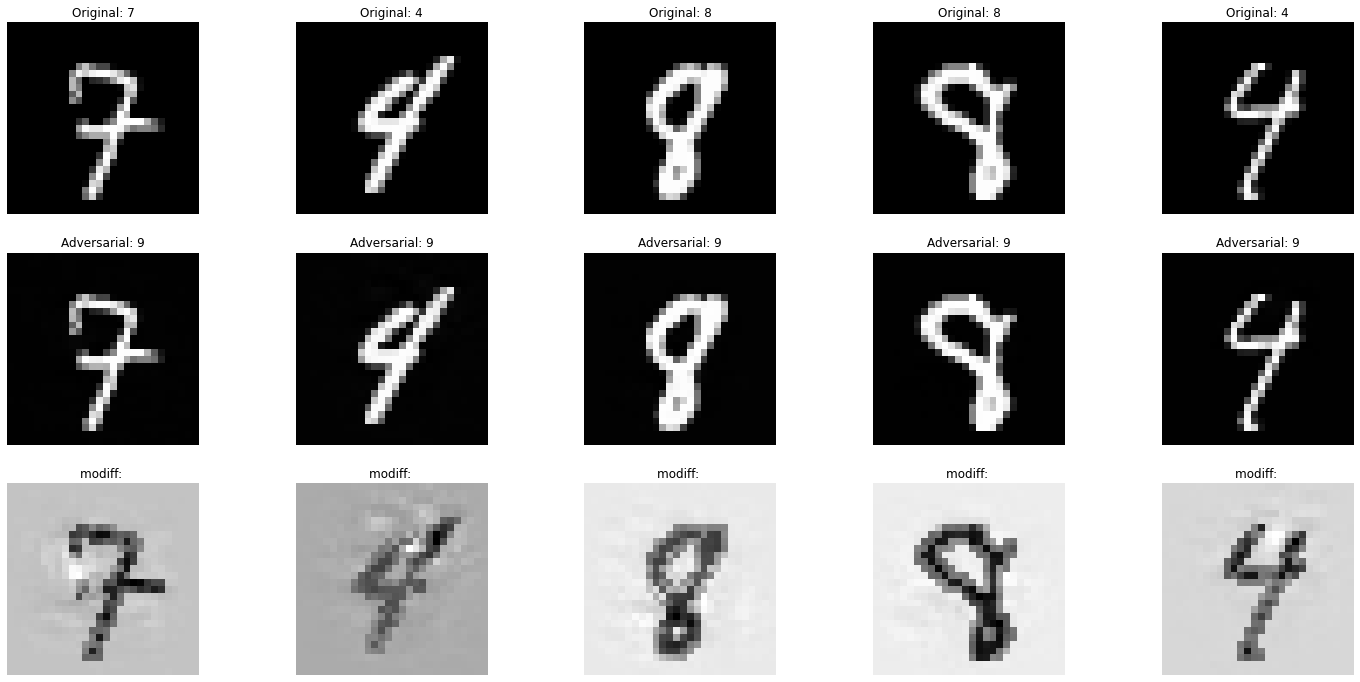

 50%|█████     | 3/6 [33:59<33:59, 679.75s/it]

Accuracy of the network on the 8840  test images: 0 %
Loss:  tensor(18.7020, device='cuda:0', grad_fn=<DivBackward0>)
c=  10
Attack Image & predict label


<ipython-input-53-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [11:17<00:00,  2.16s/it]


Correctamente etiquetados:  8840 Misclassified:  1434 Correct:  7406 Total:  10000 Incorrectos:  1160


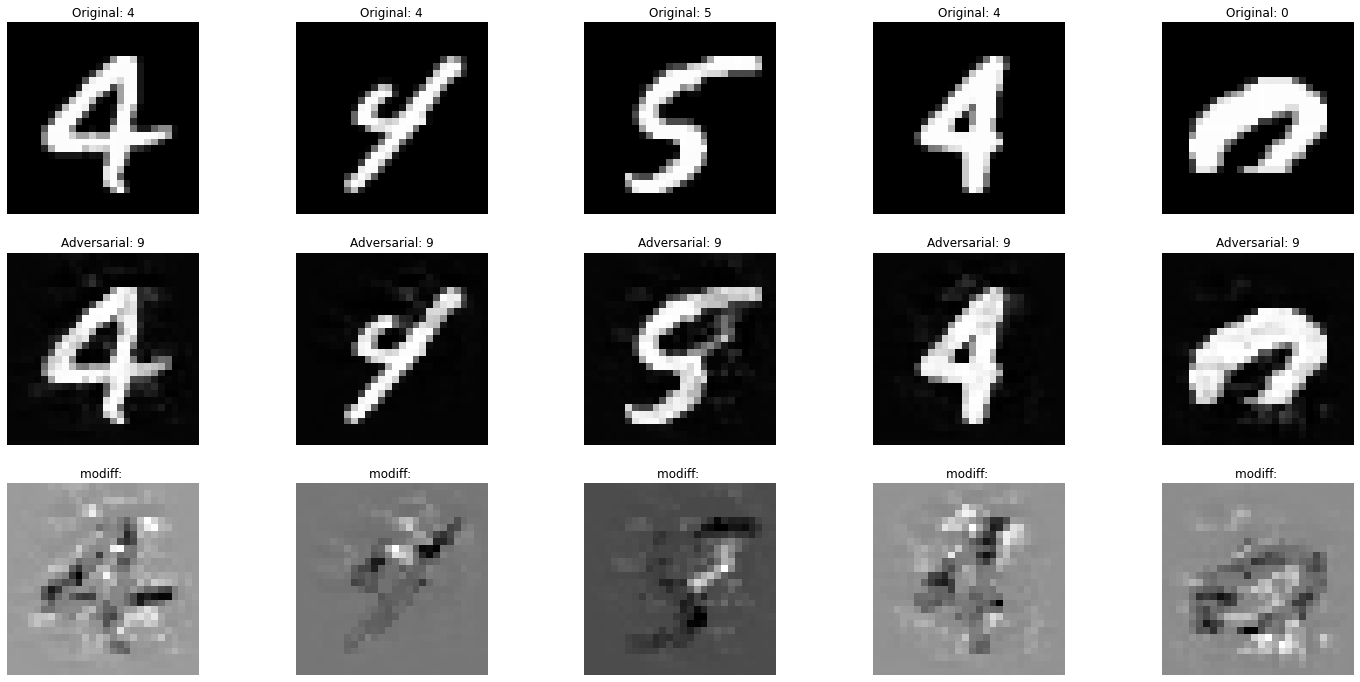

 67%|██████▋   | 4/6 [45:18<22:38, 679.42s/it]

Accuracy of the network on the 8840  test images: 16 %
Loss:  tensor(95.3156, device='cuda:0', grad_fn=<DivBackward0>)
c=  100
Attack Image & predict label


<ipython-input-53-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [11:16<00:00,  2.16s/it]


Correctamente etiquetados:  8840 Misclassified:  7650 Correct:  1190 Total:  10000 Incorrectos:  1160


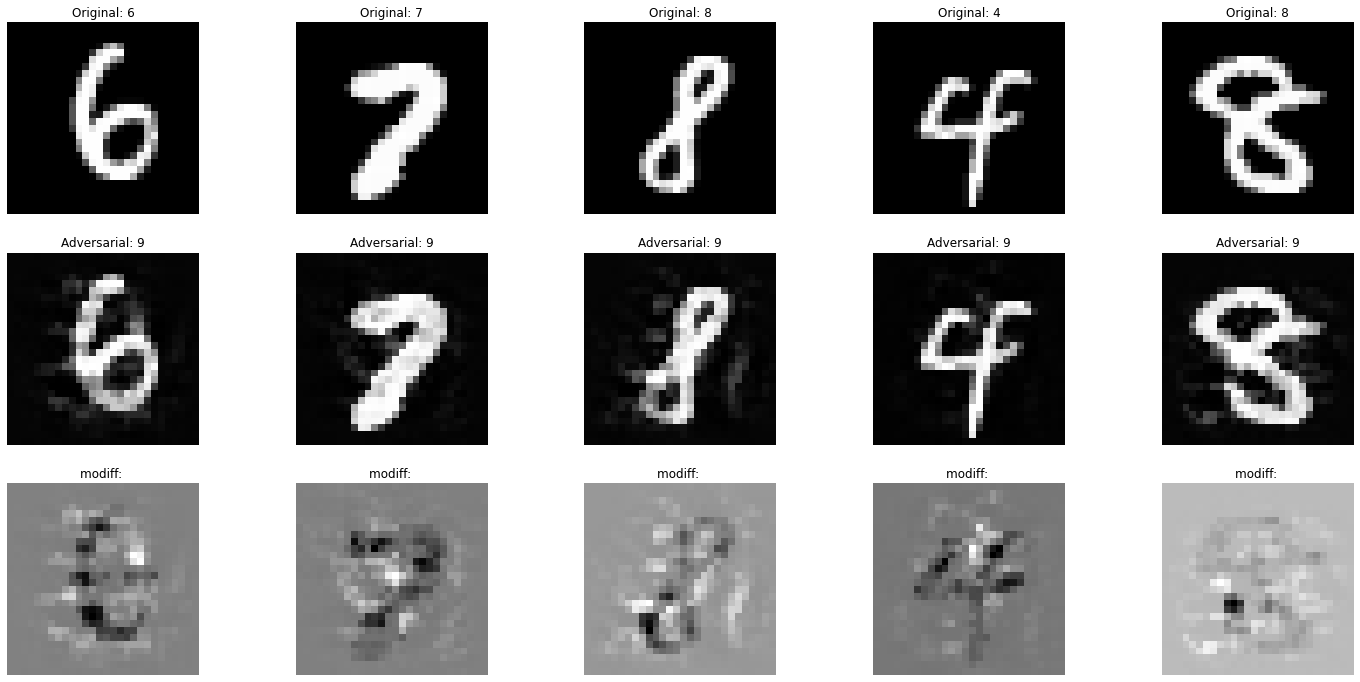

 83%|████████▎ | 5/6 [56:36<11:18, 678.90s/it]

Accuracy of the network on the 8840  test images: 86 %
Loss:  tensor(167.3508, device='cuda:0', grad_fn=<DivBackward0>)
c=  1000
Attack Image & predict label


<ipython-input-53-92c936d3861b>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/IndexingUtils.h:27.)
  j = torch.masked_select(outputs, one_hot_labels.byte())
/home/roberto/anaconda3/envs/python38/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 313/313 [11:17<00:00,  2.16s/it]


Correctamente etiquetados:  8840 Misclassified:  8707 Correct:  133 Total:  10000 Incorrectos:  1160


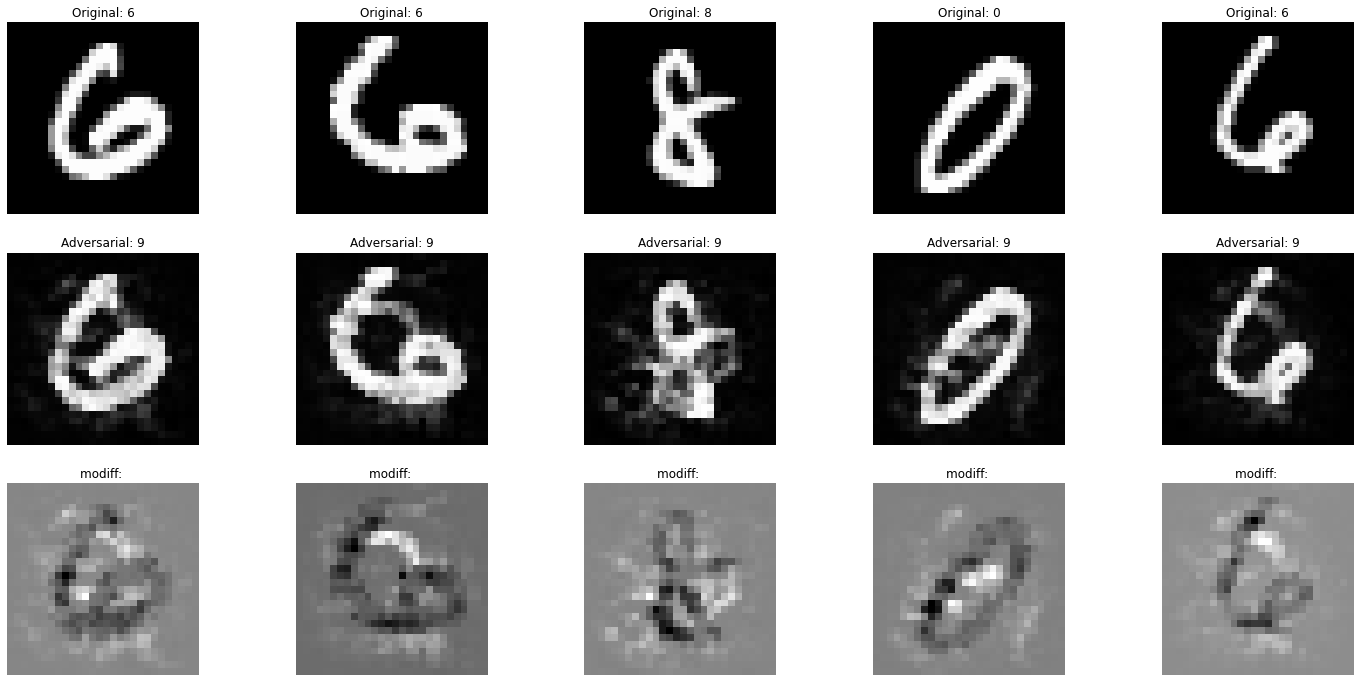

100%|██████████| 6/6 [1:07:55<00:00, 679.28s/it]

Accuracy of the network on the 8840  test images: 98 %
Loss:  tensor(237.4047, device='cuda:0', grad_fn=<DivBackward0>)


In [108]:
v_c = [0.01,0.1,1,10,100]
acc_t = []
l_t = []
for c in tqdm(v_c):
  print("c= ",c)
  m_t,c_t,loss_t=targeted(c,9)
  acc_t.append(m_t/(m_t+c_t))
  l_t.append(loss_t.item())

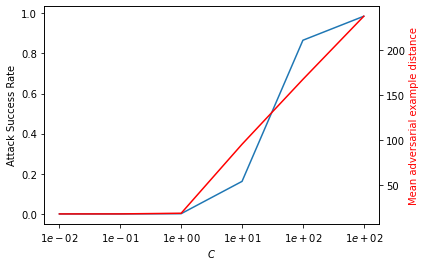

[17.982057571411133, 18.01081657409668, 18.70204734802246, 95.31559753417969, 167.35079956054688, 237.40472412109375]


In [110]:
plot_accuracies(v_c,acc_t,l_t,save="targeted")
print(l_t)